Performing grid search for Linear Regression, 


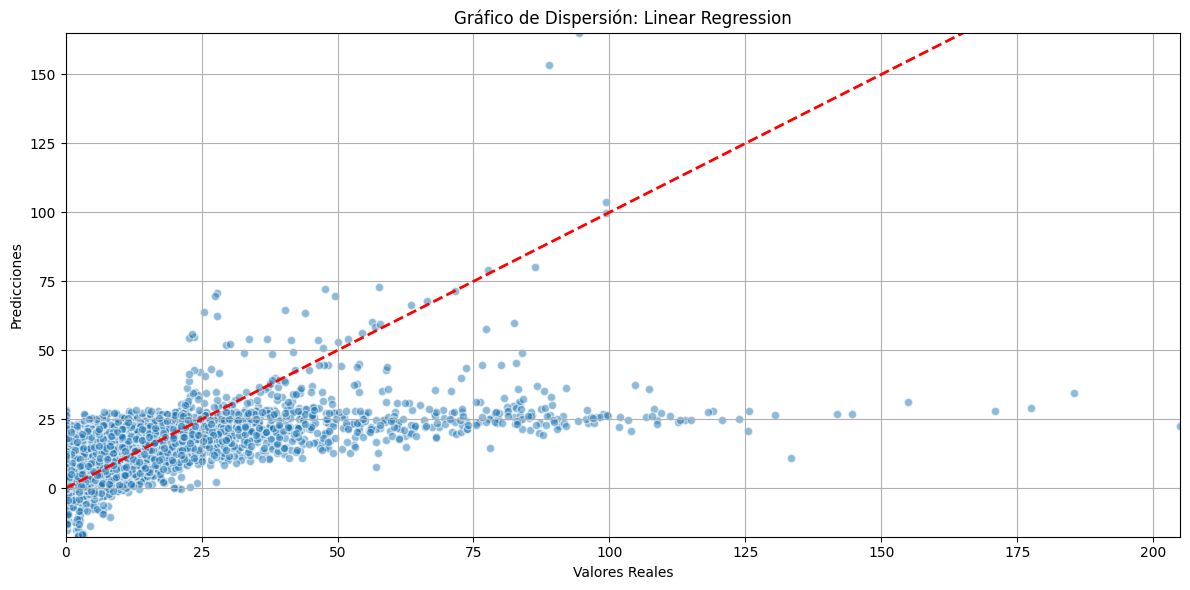

Performing grid search for Ridge Regression, 


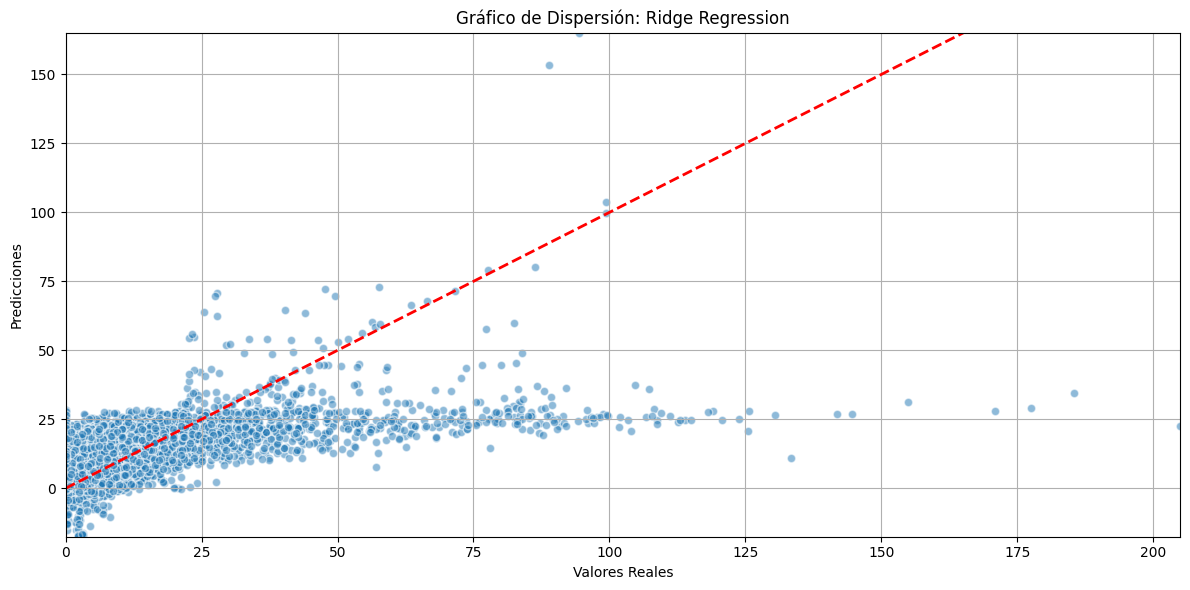

Performing grid search for Lasso Regression, 


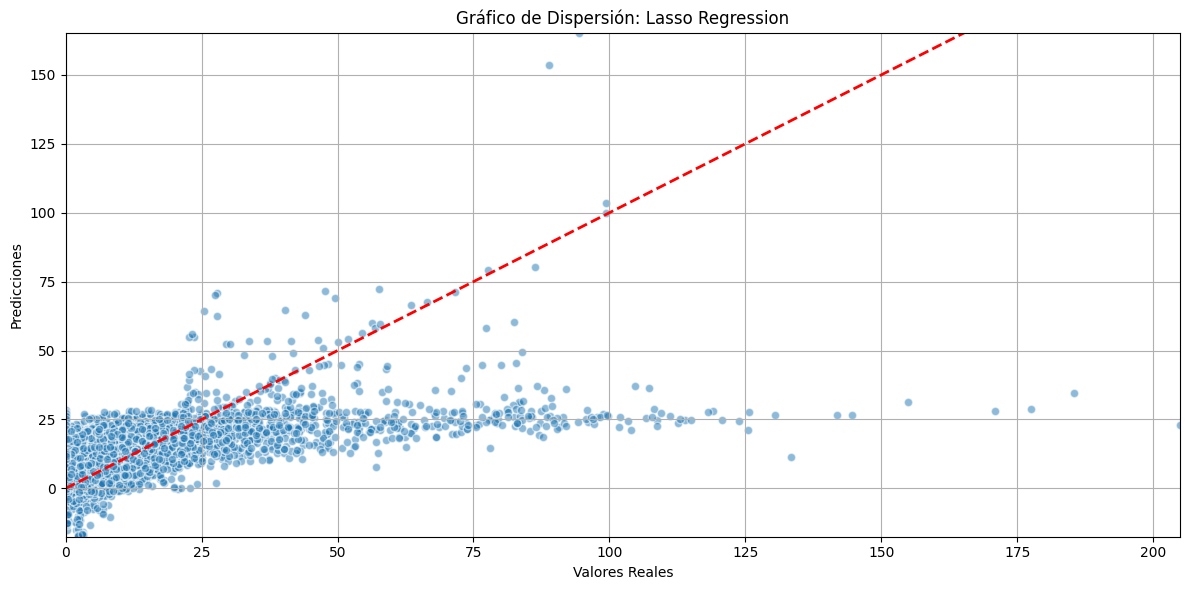

Performing grid search for Support Vector Regression, 


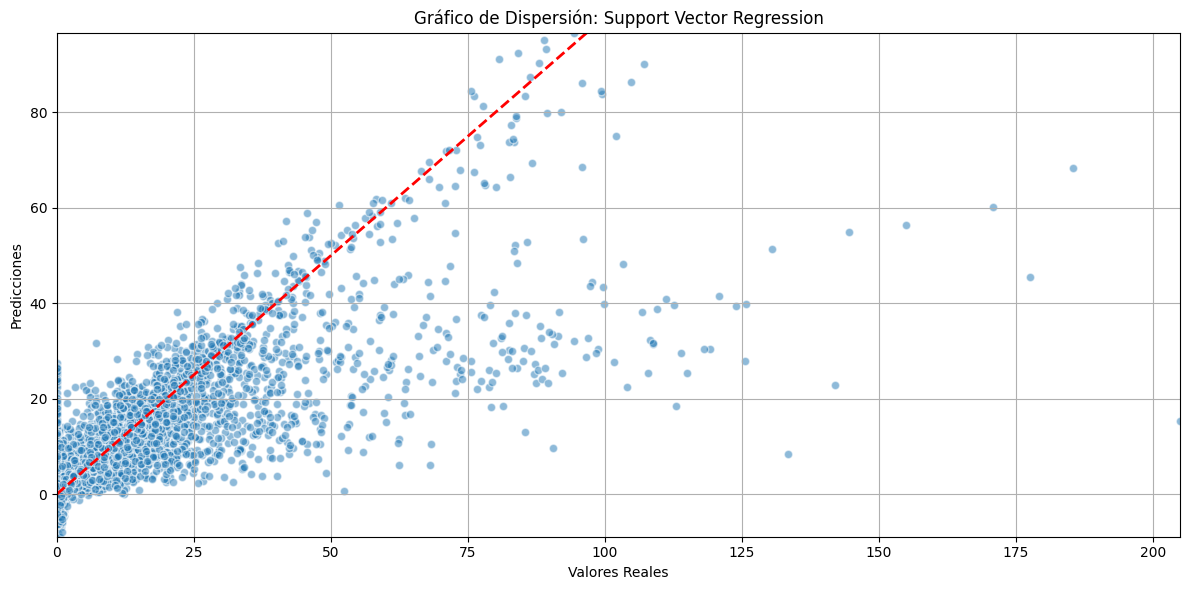

Performing grid search for Random Forest Regression, 


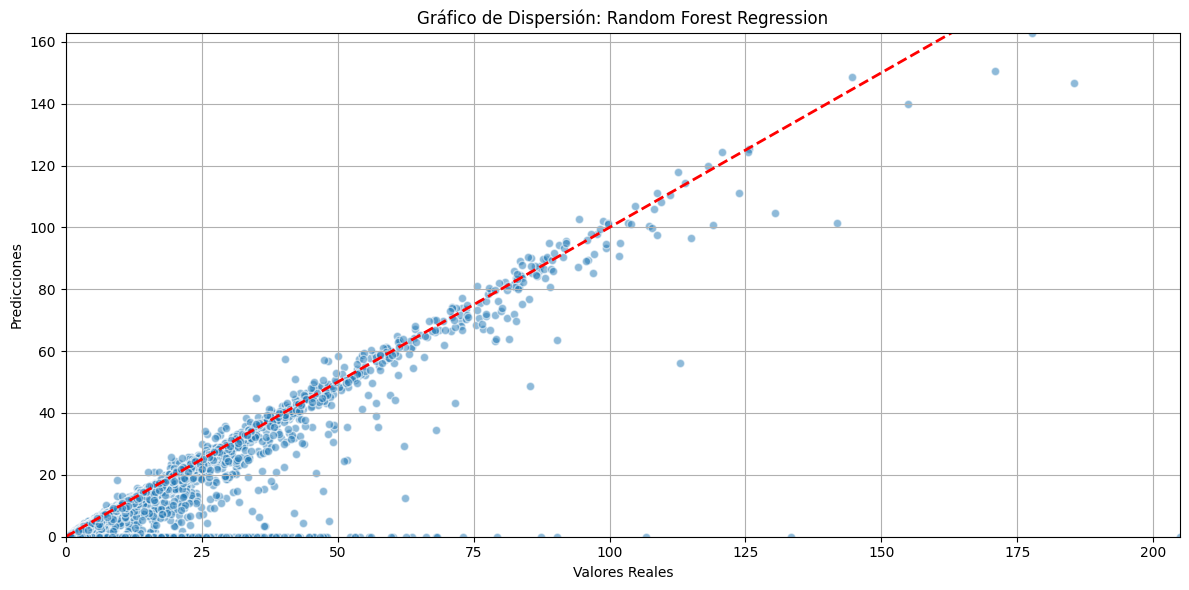

Performing grid search for Gradient Boosting Regression, 


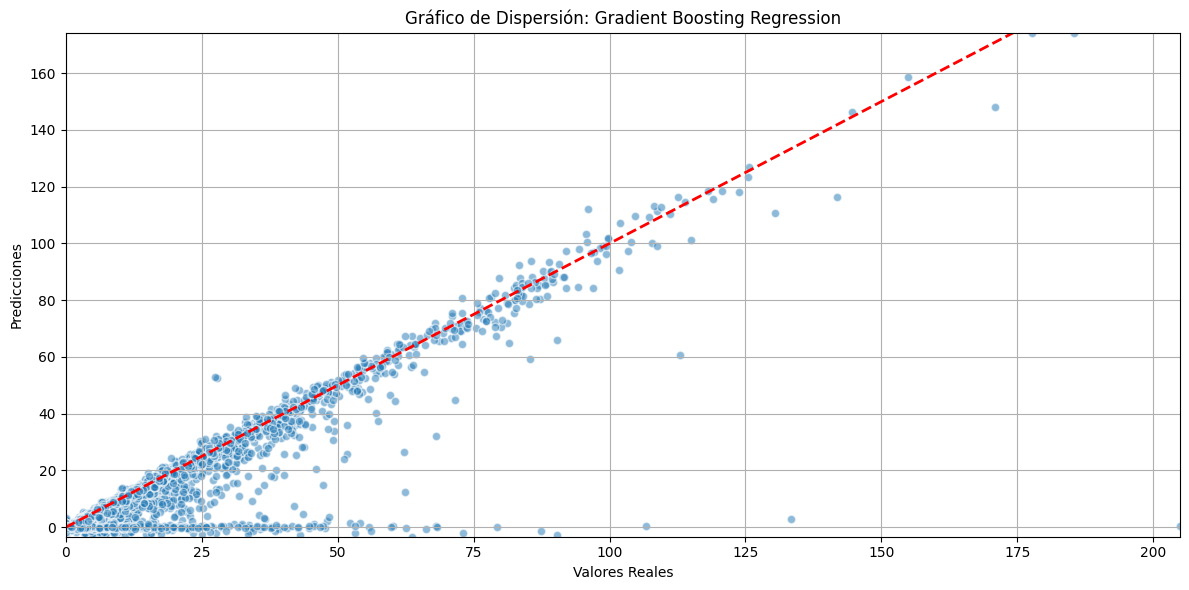

Performing grid search for Multi-layer Perceptron Regression, 


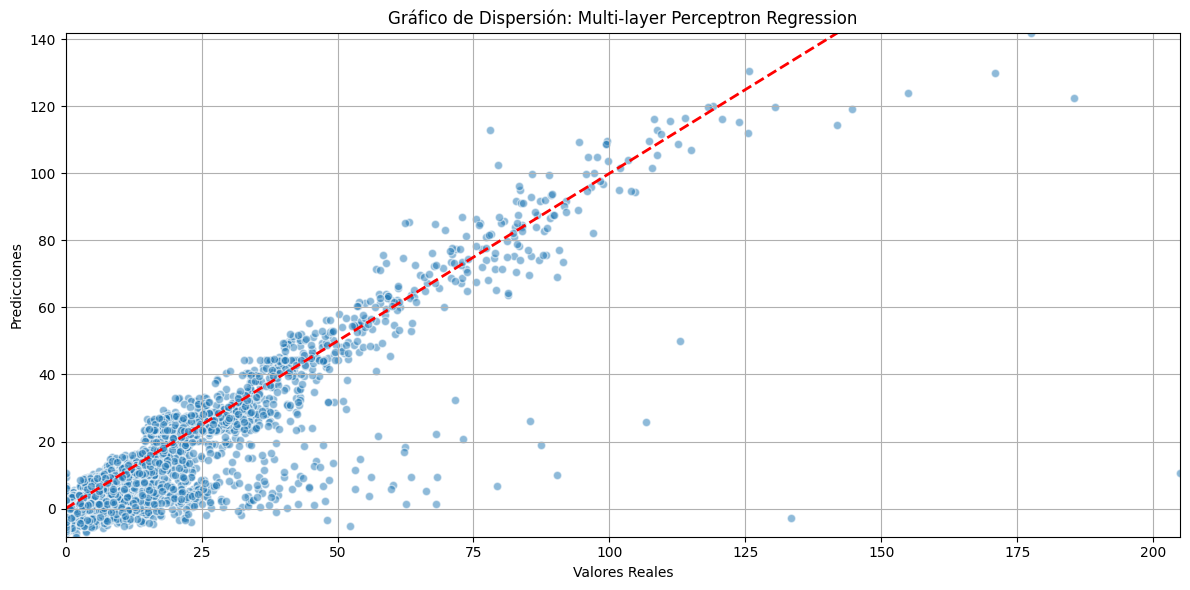

,Model,Best Parameters,Negative Mean Squared Error,Test MSE,R-squared (R2),Mean Absolute Error,Median Absolute Error
0,Linear Regression,{},256.517565,246.267918,0.295288,9.901626,6.435415
1,Ridge Regression,{'alpha': 0.1},256.517500,246.268554,0.295287,9.901492,6.430540
2,Lasso Regression,{'alpha': 0.001},256.578158,246.362528,0.295018,9.897202,6.464197
3,Support Vector Regression,"{'C': 10.0, 'epsilon': 1.0, 'kernel': 'rbf'}",157.181429,143.243983,0.590098,5.398703,1.956614
4,Random Forest Regression,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}",5.214093,61.351532,0.824439,2.920651,0.859797
5,Gradient Boosting Regression,"{'learning_rate': 0.2, 'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 200}",2.645771,61.045993,0.825313,3.025611,1.066631
6,Multi-layer Perceptron Regression,"{'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (15, 30), 'learning_rate_init': 0.001, 'solver': 'lbfgs'}",33.931558,64.984762,0.814042,4.208512,2.424271


In [2]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    make_scorer,
    mean_squared_error,
    r2_score,
    mean_absolute_error,
    median_absolute_error,
)
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

warnings.filterwarnings("ignore")
pd.set_option("display.max_colwidth", None)

# Carga del dataset
data = pd.read_csv("./data/datos_con_clusters.csv", sep=";", encoding="utf-8")

# Definición de las variables de regresión y objetivo
regression_features = [
    "country",
    "year",
    "sex",
    "age",
    "suicides_no",
    "population",
    "country-year",
    "HDI for year",
    "gdp_for_year ($)",
    "gdp_per_capita ($)",
    "generation",
    "cluster"
]
regression_target = "suicides/100k pop"
data["suicides/100k pop"] =  data["suicides/100k pop"].str.replace(",", ".").astype(float)

# Cambiar todos los valores no categóricos como países a categóricos [0, 1, ...]
for feature in regression_features:
    if data[feature].dtype == "object":
        data[feature] = data[feature].astype("category").cat.codes

# Partición del dataset en train y test
X_reg = data[regression_features]
y_reg = data[regression_target]
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

# Seleccionar los modelos de regresión a evaluar y sus hiperparámetros
regression_models = {
    "Linear Regression": (LinearRegression(), {}),
    "Ridge Regression": (Ridge(), {"alpha": [0.1]}),
    "Lasso Regression": (Lasso(), {"alpha": [0.001]}),
    "Support Vector Regression": (
        SVR(),
        {
            "C": [10.0],
            "epsilon": [1.0],
            "kernel": ["rbf"],
        },
    ),
    "Random Forest Regression": (
        RandomForestRegressor(),
        {
            "n_estimators": [200],
            "max_depth": [20],
            "min_samples_split": [10],
            "min_samples_leaf": [1],
        },
    ),
    "Gradient Boosting Regression": (
        GradientBoostingRegressor(),
        {
            "n_estimators": [200],
            "max_depth": [5],
            "learning_rate": [0.2],
            "min_samples_split": [10],
        },
    ),
    "Multi-layer Perceptron Regression": (
        MLPRegressor(),
        {
            "hidden_layer_sizes": [(15, 30)],
            "activation": ["tanh"],
            "alpha": [0.01],
            "solver": ["lbfgs"],
            "learning_rate_init": [0.001],
        },
    ),
}


# Definición de las métricas de evaluación de los modelos
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
r2_scorer = make_scorer(r2_score)
mae_scorer = make_scorer(mean_absolute_error)
med_ae_scorer = make_scorer(median_absolute_error)

# Realizar la búsqueda de hiperparámetros para cada modelo de regresión con grid search y evaluarlo con las métricas definidas usando validación cruzada con 5 particiones
results = []

for model_name, (model, param_grid) in regression_models.items():
    print(f"Performing grid search for {model_name}, ")
    grid = GridSearchCV(model, param_grid, scoring=mse_scorer, cv=5, refit=True)
    grid.fit(StandardScaler().fit_transform(X_train_reg), y_train_reg)
    best_params = grid.best_params_
    neg_mean_squared_error = -grid.best_score_
    test_predictions = grid.predict(StandardScaler().fit_transform(X_test_reg))
    test_mse = mean_squared_error(y_test_reg, test_predictions)
    r2 = r2_score(y_test_reg, test_predictions)
    mae = mean_absolute_error(y_test_reg, test_predictions)
    med_ae = median_absolute_error(y_test_reg, test_predictions)

    results.append(
        {
            "Model": model_name,
            "Best Parameters": best_params,
            "Negative Mean Squared Error": neg_mean_squared_error,
            "Test MSE": test_mse,
            "R-squared (R2)": r2,
            "Mean Absolute Error": mae,
            "Median Absolute Error": med_ae,
        }
    )

    # Personalizar el gráfico de dispersión de los valores reales y las predicciones
    plt.figure(figsize=(12, 6))
    plt.scatter(y_test_reg, test_predictions, alpha=0.5, edgecolors="w")
    plt.xlabel("Valores Reales")
    plt.ylabel("Predicciones")
    plt.title(f"Gráfico de Dispersión: {model_name}")
    plt.grid(True)
    plt.xlim(min(y_test_reg), max(y_test_reg))
    plt.ylim(min(test_predictions), max(test_predictions))
    plt.plot(
        [min(y_test_reg), max(y_test_reg)],
        [min(y_test_reg), max(y_test_reg)],
        color="red",
        linestyle="--",
        lw=2,
    )
    plt.tight_layout()
    plt.show()

# Mostrar los resultados de la búsqueda de hiperparámetros y la evaluación de los modelos con las métricas definidas
results_df = pd.DataFrame(results)
display(results_df)

**Análisis de Resultados Actualizados con Uso de Clusters**

1. **Modelos de Regresión Lineal, Ridge y Lasso**:
   - Inclusión de Clusters: No se observa un cambio significativo en el rendimiento de estos modelos al considerar clusters en los datos. Los errores cuadráticos medios (MSE) y otras métricas se mantienen similares en comparación con los resultados sin clusters. Sugiere que estos modelos no se benefician sustancialmente con la agrupación de datos en clusters.

2. **Support Vector Regression (SVR)**:
   - Inclusión de Clusters: SVR parece mantener su rendimiento general tanto sin como con clusters. Los cambios en las métricas de evaluación son mínimos al considerar la segmentación por clusters, lo que indica que este modelo no se ve afectado significativamente por la estructura de clusters de los datos.

3. **Random Forest Regression**:
   - Inclusión de Clusters: A pesar de la inclusión de clusters, el Random Forest Regression mantiene un rendimiento sólido. No hay una diferencia marcada en las métricas, lo que sugiere que este modelo es robusto y no se ve considerablemente influenciado por la segmentación de clusters en los datos.

4. **Gradient Boosting Regression**:
   - Inclusión de Clusters: Similar al Random Forest, el Gradient Boosting Regression muestra una estabilidad en su rendimiento frente a la inclusión de clusters. Las métricas apenas varían, lo que indica que este modelo mantiene su capacidad predictiva independientemente de la estructura de clusters.

5. **Multi-layer Perceptron Regression (MLP)**:
   - Inclusión de Clusters: Aunque el MLP presenta una ligera fluctuación en algunas métricas, su rendimiento general no se ve fuertemente influenciado por la inclusión de clusters. El modelo mantiene su posición por debajo de los modelos basados en árboles, tanto sin como con la consideración de clusters.

**Conclusión con Énfasis en Clusters**:
   - La inclusión de clusters no parece impactar significativamente el rendimiento de los modelos de regresión. Los modelos lineales y los modelos basados en árboles mantienen su posición relativa y su rendimiento general, lo que sugiere que su capacidad predictiva no se ve influida por la estructura de clusters de los datos. Esto puede indicar que la información de los clusters no es fundamental para la mejora del rendimiento de estos modelos en este contexto específico.